<h1>Wine Reviews Classification Models</h1>
This data is from Kaggle and was scraped from <i>Wine Enthusiast</i> magazine in November 2017. <br>The dataset can be found here: <a> https://www.kaggle.com/zynicide/wine-reviews</a>.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !ls 'drive/My Drive/ML Project-SEIS 763'


'Aaron Paper Contributions.gdoc'
'Accuracy Scores-Regression Models.docx'
 logistic_regression_wine_classifier.ipynb
 ML_GroupProject_WineReview_Draft.pptx
 ML-project-report.docx
 nonprinting_cleanup.txt
 RandomForest_CategoricalFeat_predictingPrice.ipynb
 RandomForest_V2.ipynb
 RandomForest_w_GetDummy.ipynb
"Sara's Write-Up.gdoc"
 wine-classification-models.ipynb
 wine_reviews.csv
 wine-reviews-initial.ipynb
 wine-reviews-regression-models.ipynb
 wine-reviews-text-vectorizer-classification.ipynb


In [0]:
# create pandas dataframe
# wine = pd.read_csv('drive/My Drive/ML Project-SEIS 763/wine_reviews.csv', encoding='latin-1')
wine = pd.read_csv('wine_reviews.csv', encoding='latin-1')

In [0]:
# drop unnecessary columns
wine = wine.drop(columns=['Unnamed: 0','region_2', 'taster_twitter_handle','designation', 'region_1'])
wine.head(2)

,country,description,points,price,province,taster_name,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Kerin OÛªKeefe,Nicosia 2013 VulkÌÊ Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


In [0]:
wine.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [0]:
# check for missing values
null_values = wine.isnull().values.any()
number_null = wine.isnull().sum()
number_null

country           63
description        0
points             0
price           8996
province          63
taster_name    26244
title              0
variety            1
winery             0
dtype: int64

In [0]:
# check for duplicate entries
wine[wine.duplicated('description', keep = False)].sort_values('description').head(10)

,country,description,points,price,province,taster_name,title,variety,winery
67614,US,"100% Malbec, it's redolent with dark plums, wi...",87,20.0,Washington,Sean P. Sullivan,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
46540,US,"100% Malbec, it's redolent with dark plums, wi...",87,20.0,Washington,Sean P. Sullivan,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
119702,US,"100% Sangiovese, this pale pink wine has notes...",88,18.0,Washington,Sean P. Sullivan,Ross Andrew 2013 Meadow RosÌ© (Columbia Valley...,RosÌ©,Ross Andrew
72181,US,"100% Sangiovese, this pale pink wine has notes...",88,18.0,Washington,Sean P. Sullivan,Ross Andrew 2013 Meadow RosÌ© (Columbia Valley...,RosÌ©,Ross Andrew
73731,France,"87-89 Barrel sample. A pleasurable, perfumed w...",88,NaN,Bordeaux,Roger Voss,ChÌ¢teau Lalande-Borie 2008 Barrel sample (Sa...,Bordeaux-style Red Blend,ChÌ¢teau Lalande-Borie
100745,France,"87-89 Barrel sample. A pleasurable, perfumed w...",88,NaN,Bordeaux,Roger Voss,ChÌ¢teau Lalande-Borie 2008 Barrel sample (Sa...,Bordeaux-style Red Blend,ChÌ¢teau Lalande-Borie
73730,France,87-89 Barrel sample. Minty aromas give lifted ...,88,NaN,Bordeaux,Roger Voss,ChÌ¢teau Haut-Sarpe 2008 Barrel sample (Saint...,Bordeaux-style Red Blend,ChÌ¢teau Haut-Sarpe
100744,France,87-89 Barrel sample. Minty aromas give lifted ...,88,NaN,Bordeaux,Roger Voss,ChÌ¢teau Haut-Sarpe 2008 Barrel sample (Saint...,Bordeaux-style Red Blend,ChÌ¢teau Haut-Sarpe
73729,France,87-89 Barrel sample. With its lovely fresh fru...,88,NaN,Bordeaux,Roger Voss,ChÌ¢teau Bertineau Saint-Vincent 2008 Barrel s...,Bordeaux-style Red Blend,ChÌ¢teau Bertineau Saint-Vincent
100743,France,87-89 Barrel sample. With its lovely fresh fru...,88,NaN,Bordeaux,Roger Voss,ChÌ¢teau Bertineau Saint-Vincent 2008 Barrel s...,Bordeaux-style Red Blend,ChÌ¢teau Bertineau Saint-Vincent


In [0]:
# drop duplicates
wine = wine.drop_duplicates('description')
len(wine)

119955

<h3>There are some outliers for price (i.e. one $3300 botttle). Using 1.5 the IQ range as a guide, I'm going to remove wines costing more than 100 from the dataset.</h3>

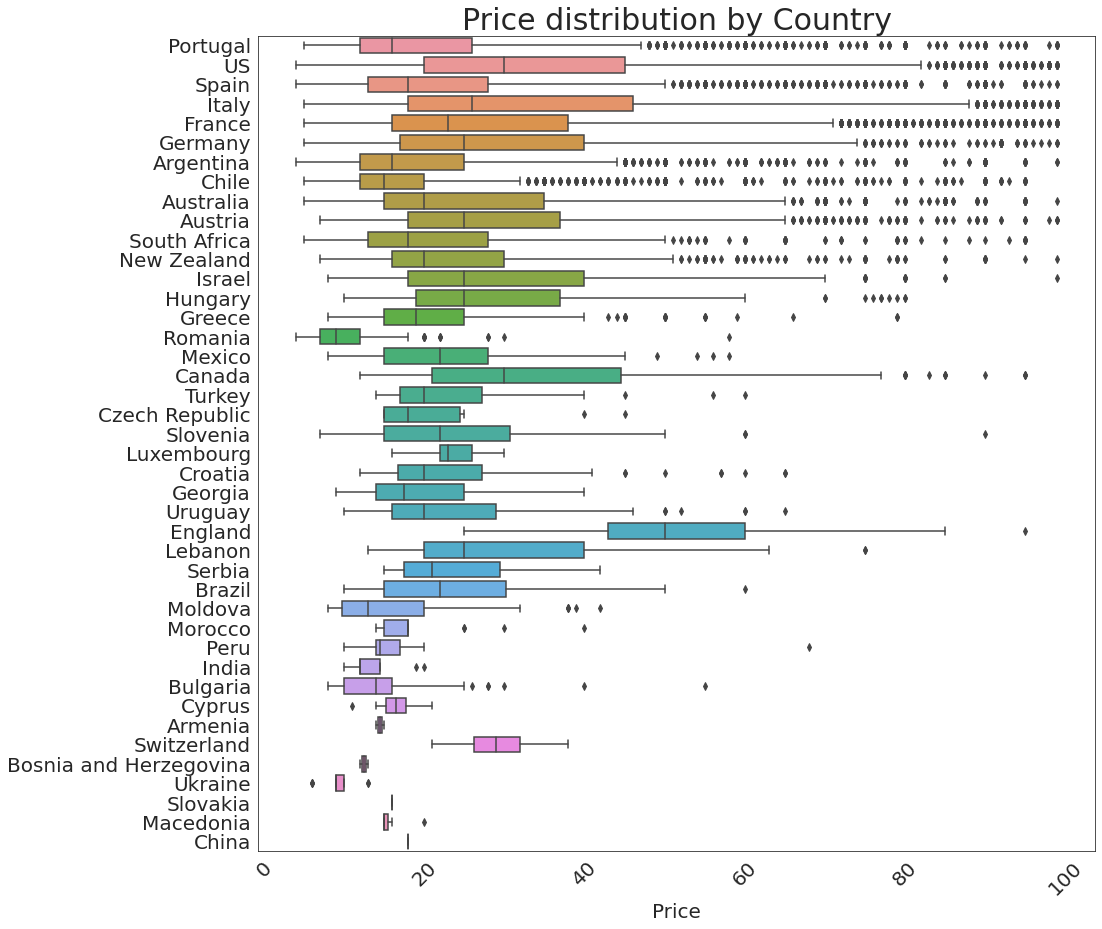

In [0]:
df_minus_outliers = wine[wine['price'] < 100]

sns.set_style('white')
fig, ax = plt.subplots(figsize = (15,15))
chart = sns.boxplot(y='country', x='price', data=df_minus_outliers, ax=ax)
plt.xticks(rotation=45)
plt.title("Price distribution by Country", fontsize=30)
plt.xlabel('Price', fontsize=20)
plt.ylabel("", fontsize=15)
plt.tick_params(labelsize=20)
plt.show()

In [0]:
# What is the correlation between points and price?
wine.corr()

,points,price
points,1.000000,0.416566
price,0.416566,1.000000


<h4>Points and price are moderately correlated.</h4>

In [0]:
# Is there a correlation between points and the length of the description?
length_desc = wine.assign(description_length = wine['description'].apply(len))
length_desc.head()

,country,description,points,price,province,taster_name,title,variety,winery,description_length
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Kerin OÛªKeefe,Nicosia 2013 VulkÌÊ Bianco (Etna),White Blend,Nicosia,172
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,227
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,186
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,199
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,249


In [0]:
corr = length_desc.corr()
corr

,points,price,description_length
points,1.000000,0.416566,0.562598
price,0.416566,1.000000,0.252335
description_length,0.562598,0.252335,1.000000


<h4>A little stronger correlation between points and description length, indicating that a taster might be inclined to write more about a more highly rated wine.</h4>

According to Wine Spectator, 
95-100 Classic: a great wine
90-94 Outstanding: a wine of superior character and style
85-89 Very good: a wine with special qualities
80-84 Good: a solid, well-made wine


In [0]:
# simplify points to make more useful for machine learning
def simplify_points(points):
    if points <= 84:
        return 1
    elif points >=85 and points <=89:
        return 2
    elif points >=90 and points <=94:
        return 3
    else:
        return 4
    
length_desc = length_desc.assign(points_simplified = length_desc['points'].apply(simplify_points))
length_desc.sample(5)


,country,description,points,price,province,taster_name,title,variety,winery,description_length,points_simplified
78001,US,"All stainless-fermented and aged, this deserve...",91,22.0,Oregon,Paul Gregutt,Amalie Robert 2014 Her Silhouette Chardonnay (...,Chardonnay,Amalie Robert,357,3
113837,Spain,"Loamy cassis, black plum and blueberry aromas ...",87,50.0,Catalonia,Michael Schachner,Josep Grau Viticultor 2012 Dosterras Red (Mont...,Red Blend,Josep Grau Viticultor,211,2
93924,France,"A concentrated and ripe wine, dominated by spi...",90,NaN,Burgundy,Roger Voss,Vignerons des Terres SecrÌ¬tes 2008 Terra Inco...,Chardonnay,Vignerons des Terres SecrÌ¬tes,134,3
66188,France,"A fresh, fruity branded Bordeaux from the prod...",85,12.0,Bordeaux,Roger Voss,La Patache 2006 MÌ©doc,Cabernet Sauvignon,La Patache,190,2
126717,Spain,Dill and butter aromas announce aging in Ameri...,86,15.0,Northern Spain,Michael Schachner,MartÌ_n CÌ_dax 2005 Ergo (Rioja),Tempranillo,MartÌ_n CÌ_dax,313,2


In [0]:
length_desc.dropna(subset=['price', 'description_length', 'points_simplified'])

,country,description,points,price,province,taster_name,title,variety,winery,description_length,points_simplified
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,227,2
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,186,2
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,199,2
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,249,2
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,261,2
...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,Anna Lee C. Iijima,Dr. H. Thanisch (Erben MÌ_ller-Burggraef) 2013...,Riesling,Dr. H. Thanisch (Erben MÌ_ller-Burggraef),228,3
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Paul Gregutt,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,233,3
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,GewÌ_rztraminer,Domaine Gresser,225,3
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Roger Voss,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,216,3


In [0]:
df_less_outliers = length_desc[length_desc['price'] < 800]
df_less_outliers['price'].max()

790.0

In [0]:
df_less_outliers.head()

,country,description,points,price,province,taster_name,title,variety,winery,description_length,points_simplified
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,227,2
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,186,2
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,199,2
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,249,2
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,261,2


In [0]:
df_less_outliers.astype({'price': 'int64'}).dtypes

country               object
description           object
points                 int64
price                  int64
province              object
taster_name           object
title                 object
variety               object
winery                object
description_length     int64
points_simplified      int64
dtype: object

In [0]:
# add vintage column
df_less_outliers[['vintage']] = df_less_outliers.title.str.extract(r'(\d{4})', expand=True)
# drop missing values
df_less_outliers.dropna(inplace=True)
df_less_outliers=df_less_outliers.astype({'vintage': int})
df_less_outliers.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(85267, 12)

In [0]:
# balance classes
# downsample the majority classes
from sklearn.utils import resample
# Separate majority and minority classes
df_1 = df_less_outliers[df_less_outliers.points_simplified==1]
df_2 = df_less_outliers[df_less_outliers.points_simplified==2]
df_3 = df_less_outliers[df_less_outliers.points_simplified==3]
df_4 = df_less_outliers[df_less_outliers.points_simplified==4]
 
# Downsample majority class
df_majority_1 = resample(df_1, 
                         replace=False,    # sample without replacement
                         n_samples=1641,     # to match minority class
                         random_state=1)  # reproducible results
                    
df_majority_2 = resample(df_2, 
                         replace=False,    # sample without replacement
                         n_samples=1641,     # to match minority class
                         random_state=1)  # reproducible results 
df_majority_3 = resample(df_3, 
                         replace=False,    # sample without replacement
                         n_samples=1641,     # to match minority class
                         random_state=1)  # reproducible results                          

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_1, df_majority_2, df_majority_3, df_4])
 
# Display new class counts
df_downsampled.points_simplified.value_counts()

3    1641
2    1641
1    1641
4    1641
Name: points_simplified, dtype: int64

In [0]:
# df_downsampled = wine
# wine_features = wine.drop("points_simplified", axis=1)

# #  temp
# wine_features = wine[['description_length','province','price','vintage']]

# # scale and one-hot encode categorical features
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder

# ct = ColumnTransformer([
#     ("onehot", OneHotEncoder(sparse=False), ['province'])
# ])
# ct.fit(wine_features)
# X = ct.transform(wine_features)

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, wine.points_simplified, test_size=0.2, random_state=0)

# ct.get_feature_names()

# Can we predict points based on price and description length?
X = df_downsampled[['price', 'description_length', 'vintage']].values
y = df_downsampled['points_simplified'].values

In [0]:
#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

#Normalizing the features
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)



In [0]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

classifiers = [
    LogisticRegression(class_weight='balanced'),
    KNeighborsClassifier(8),
    SVC(kernel="rbf", class_weight = 'balanced', probability=True),
    DecisionTreeClassifier(class_weight='balanced'),
    RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced'),
    GaussianNB()
    ]


In [0]:
# Fit models, then return model accuracy
for classifier in classifiers:
    model = classifier.fit(X_train, y_train)
    print(classifier)
    print("model score: %.3f" % model.score(X_test, y_test))

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
model score: 0.619
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')
model score: 0.597
SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
model score: 0.628
DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
         

In [0]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# ldaObj = LDA(n_components=2)
# X_train = ldaObj.fit_transform(X_train, y_train)
# X_test = ldaObj.transform(X_test)
# components_variance = ldaObj.explained_variance_ratio_

In [0]:
#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10)
print(modelAccuracies.mean())
print(modelAccuracies.std())

0.49824902908023116
0.027447938064677307
